<h1 style="color:blue;text-align:center;font-size:300%;font-family:verdana;"> Customer Segmentation</h1>

As data analysts at Commerce-e, a leading company in its field, we were tasked by the VP of Marketing and Sales to analyze customer purchase data and segment clients for targeted advertising. 

The task involves data exploration, identifying missing values, cleaning the dataset, and engineering key features such as total revenue per customer, number of transactions, and recency of the last transaction.

After preparing the data, we perform customer segmentation by removing the customer ID and analyzing behavioral patterns. We check for outliers, determine the optimal number of clusters using the elbow method and dendrogram, and apply a clustering algorithm accordingly.

We then evaluate clustering performance, assign each customer to a segment, and visualize the segmentation results through various 2D and 3D plots based on revenue, frequency, and recency.

### Import Python Libraries

In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

import datetime as dt

### Import the data

In [73]:
online = pd.read_csv('OnlineRetail.csv', encoding='unicode_escape')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


The Online Retail dataset contains transactional data from a UK-based online store. Each row represents a product purchased as part of a customer’s order. 

The dataset includes the following columns:

 * InvoiceNo: Unique identifier for each invoice (i.e., transaction).

 * StockCode: Unique product code.

 * Description: Description of the product.

 * Quantity: Number of items purchased in the transaction.

 * InvoiceDate: Date and time the transaction occurred.

 * UnitPrice: Price per item in GBP (£).

 * CustomerID: Anonymized unique identifier for each customer.

 * Country: Country of the customer.

### Check the shape of the data

In [74]:
print(online.shape)

(541909, 8)


---
# Exploratory Data Analysis

### Check the info

In [75]:
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Generate some descriptive statistics

In [76]:
online.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Check how much of the data per feature has null values, percentage-wise

In [77]:
online.isnull().sum()/(len(online))*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

___
# Feature Engineering

### Drop the null values

In [78]:
online = online.dropna()

### Check again the shape of the data

In [79]:
online.shape

(406829, 8)

### Change the customer id feature to a string type

In [80]:
online['CustomerID'] = online['CustomerID'].astype(str)

### Change the invoice date to a datetime type
use format='%d-%m-%Y %H:%M'

In [81]:
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'], format='%d-%m-%Y %H:%M')

### Create a feature of the total amount spent
Total_Amount_Spent = quantity * unit price

In [82]:
online['Total_Amount_Spent']= online['Quantity'] * online['UnitPrice']

We created the Total_Amount_Spent feature by multiplying Quantity and UnitPrice to calculate the total value of each transaction line. 

This feature is important because it gives us a clear measure of how much each customer spent on each purchase. 

It plays a key role in analyzing customer behavior, segmenting clients based on spending, and identifying high-value customers for targeted marketing.

### Check the head of the data

In [83]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Amount_Spent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Sum the total amount spent per customer id to a new data frame

In [84]:
# total amount
total_amount = online['Total_Amount_Spent'].groupby(online['CustomerID']).sum()
total_amount = pd.DataFrame(total_amount).reset_index()
total_amount.head()

,CustomerID,Total_Amount_Spent
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### Count the invoice numbers per customer id to a new data frame and print the head

In [85]:
# total transactions
transactions = online['InvoiceNo'].groupby(online['CustomerID']).count()
transaction = pd.DataFrame(transactions).reset_index()
transaction.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


###  Calculate the number of days between the company's most recent transaction and each customer's most recent transaction. Create a new DataFrame containing the customer id and the duration from their last transaction. Print the first few rows of this DataFrame.

In [21]:
# Latest transaction
final = online['InvoiceDate'].max()
online['Last_transaction'] = final - online['InvoiceDate']
LT = online.groupby(online['CustomerID'])['Last_transaction'].min()
LT = pd.DataFrame(LT).reset_index()
LT.head()

,CustomerID,Last_transaction
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


### Merge the total amount spent data frame and the invoice number count data frame

In [86]:
# Merge dataframes
online_new = pd.merge(total_amount,transaction,how='inner',on='CustomerID')
online_new.head()

,CustomerID,Total_Amount_Spent,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


### Merge the above data frame and the last transaction data frame

In [87]:
online_new = pd.merge(online_new,LT,how='inner',on='CustomerID')
online_new.head()

,CustomerID,Total_Amount_Spent,InvoiceNo,Last_transaction
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


### Change the last transaction column to show only the days
use datetime's days method

In [88]:
online_new['Last_transaction'] = online_new['Last_transaction'].dt.days
online_new.head()

,CustomerID,Total_Amount_Spent,InvoiceNo,Last_transaction
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


### Make sure the features names are: CustomerID, Total_Amount_Spent, Count_invoice, Last_transaction

In [89]:
# Renaming features
online_new.rename(columns={'InvoiceNo':'Count_invoice'},inplace=True)

### Check the shape of the new data frame

In [26]:
online_new.shape

(4372, 4)

### Drop the customer id column

In [90]:
online_new.drop('CustomerID',axis=1,inplace=True)

### Final data

In [91]:
online_new

,Total_Amount_Spent,Count_invoice,Last_transaction
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309
...,...,...,...
4367,180.60,10,277
4368,80.82,7,180
4369,176.60,13,7
4370,2094.88,756,3


___
# Segmentation

As part of the customer segmentation process, the expert mentioned in the task highlighted that customers with indices 1, 4302, 2438, and 261 are likely to be significantly different from one another. 

To examine his claim, we created a new DataFrame containing only these specific rows from the dataset. This allows us to analyze and compare their behavior across key features such as total amount spent, number of transactions, and recency. 

By isolating these cases, we can better understand their position within the overall customer distribution and evaluate whether they indeed belong to different segments.

In [92]:
indices=[1,4302,2438,261]
samples=pd.DataFrame(online_new.loc[indices],columns=online_new.keys())
display(samples)

,Total_Amount_Spent,Count_invoice,Last_transaction
1,4310.00,182,1
4302,212.96,18,150
2438,12433.34,495,3
261,3817.08,232,0


### Display a heatmap of the indices data frame percentiles
print the annotations

,Total_Amount_Spent,Count_invoice,Last_transaction
1,92.7,88.0,3.5
4302,17.6,26.0,76.1
2438,98.5,98.0,8.3
261,91.3,91.4,1.2


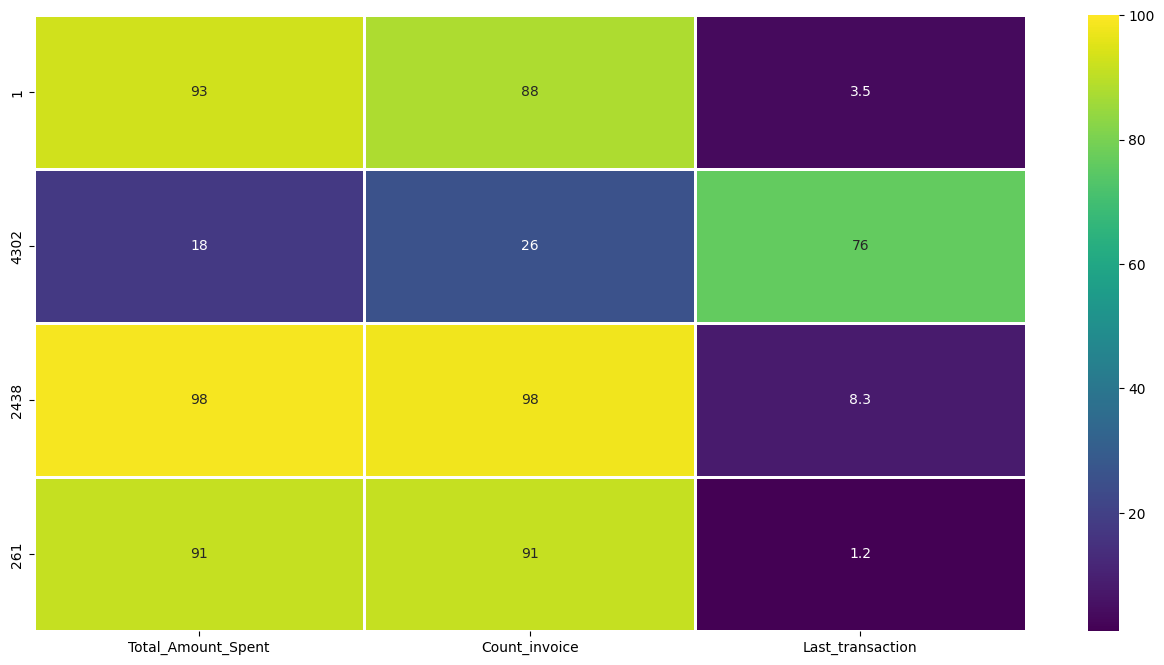

In [93]:
percentiles=online_new.rank(pct=True)
percentiles=(percentiles*100).apply(lambda x:np.round(x,decimals=1))
percentiles.head()
percentiles=percentiles.loc[indices]
plt.figure(figsize=(16,8))
sns.heatmap(percentiles,vmin=1,vmax=100,annot=True,cmap='viridis',
           linecolor='white',linewidths=1)
display(percentiles)

1. Customer 4302 stands out as very different from the others:

    * Has very low total spending (17.6) and few transactions (26).

    * Made their last purchase a long time ago (76.1 days ago).

    * This customer may be inactive or disengaged.

2. Customers 1, 2438, and 261:

    * All show high spending (above 90) and a high number of transactions (above 88).

    * Their last purchase was recent, especially for customer 261 (only 1.2 days ago).

    * These customers are likely loyal and active.

3. Customer 2438 has the highest values overall, indicating they might be one of the top customers in terms of both frequency and monetary value.

The heatmap confirms the expert's suggestion: these customers are clearly from different behavioral segments. 

Customer 4302 is inactive/low-value, while the others are active/high-value. 

This demonstrates the usefulness of clustering and segmentation for targeted marketing strategies.

### Import train_test_split, DecisionTreeRegressor, r2_score if you haven't done this already

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

### What are the data frames keys?

In [95]:
online_new.keys()

Index(['Total_Amount_Spent', 'Count_invoice', 'Last_transaction'], dtype='object')

### Check the r^2 score using decision tree regressor for each feature with the other features
make each feature a traget and split to training set and test set and check the r2 score

In [96]:
for i in online_new.keys():
    new_data=online_new.drop(i,axis=1)
    X_train,X_test,y_train,y_test=train_test_split(new_data,online_new[i],test_size=0.30,random_state=101)
    regressor=DecisionTreeRegressor(random_state=101)
    regressor.fit(X_train,y_train)
    pred=regressor.predict(X_test)
    score=r2_score(y_test,pred)
    print(i, 'score is:', score)

Total_Amount_Spent score is: 0.030708742494592434
Count_invoice score is: -0.20205154714672657
Last_transaction score is: -0.44900700926098147


### Print a boxplot to check for outliers

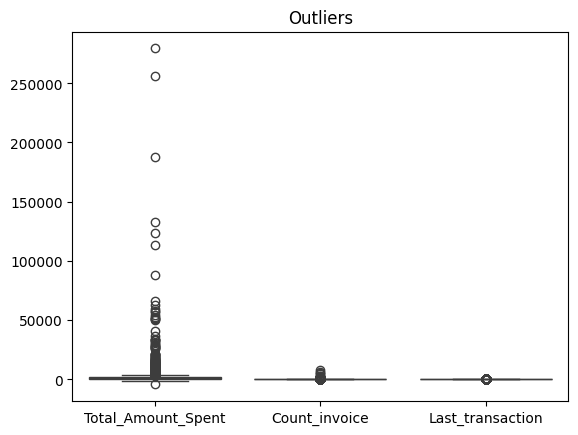

In [97]:
sns.boxplot(data=online_new)
plt.title('Outliers');

### Use Tukey's rule for finding outliers for each feature

Tukey’s Rule (also called the IQR method) is a simple and effective statistical technique to detect outliers in a dataset. It uses the Interquartile Range (IQR), which measures the spread of the middle 50% of the data.

Tukey's Rule helps us find extremely low or high values that are far from the majority of the data. These outliers can distort clustering or predictive models, so it’s common to detect (and sometimes remove) them before modeling.

In [98]:
outliers=np.array([],dtype='int64')
for feature in online_new.keys():
    Q1=np.percentile(online_new[feature],25)
    Q3=np.percentile(online_new[feature],75)
    step=(Q3-Q1)*1.5
    print('Data points considered outliers for the feature %s are:' %feature)
    outliers_pts=online_new[~((online_new[feature]>=Q1-step)&
                              (online_new[feature]<=Q3+step))]
    outliers=np.append(outliers,
                       outliers_pts.index.values.astype('int64'))
    #display(outliers)
    display(outliers_pts.index.values.astype('int64'))

Data points considered outliers for the feature Total_Amount_Spent are:


array([   1,   10,   12,   15,   27,   50,   55,   66,   67,   69,   70,
         71,   73,   75,   79,   84,   86,  100,  101,  103,  105,  106,
        110,  112,  115,  122,  124,  145,  154,  156,  157,  167,  169,
        174,  178,  179,  191,  198,  204,  226,  231,  232,  238,  248,
        256,  261,  262,  266,  273,  276,  277,  278,  282,  290,  295,
        298,  300,  302,  308,  315,  318,  328,  329,  330,  331,  333,
        334,  338,  344,  350,  365,  385,  393,  395,  413,  436,  450,
        458,  464,  472,  477,  479,  487,  491,  498,  507,  510,  516,
        521,  525,  543,  556,  561,  564,  565,  568,  569,  572,  575,
        576,  579,  587,  595,  605,  607,  638,  640,  652,  657,  669,
        698,  700,  701,  703,  737,  740,  745,  747,  756,  786,  788,
        803,  809,  822,  836,  843,  859,  874,  891,  899,  909,  926,
        942,  959,  988, 1005, 1016, 1054, 1062, 1067, 1078, 1082, 1095,
       1123, 1136, 1144, 1188, 1206, 1219, 1221, 12

Data points considered outliers for the feature Count_invoice are:


array([  12,   15,   55,   66,   69,   71,   86,  100,  101,  103,  105,
        106,  112,  115,  138,  154,  156,  157,  178,  191,  226,  231,
        232,  238,  261,  276,  277,  278,  290,  295,  298,  302,  308,
        318,  330,  331,  334,  338,  344,  393,  395,  407,  413,  450,
        479,  487,  507,  510,  521,  543,  556,  561,  564,  568,  575,
        576,  579,  587,  595,  605,  615,  635,  638,  657,  674,  698,
        702,  703,  740,  752,  803,  809,  831,  836,  843,  845,  859,
        889,  899,  922,  942,  988, 1005, 1016, 1042, 1053, 1062, 1078,
       1134, 1136, 1206, 1211, 1219, 1221, 1250, 1251, 1259, 1266, 1273,
       1274, 1282, 1293, 1295, 1300, 1302, 1337, 1345, 1348, 1361, 1363,
       1367, 1368, 1370, 1437, 1442, 1447, 1466, 1495, 1510, 1512, 1523,
       1528, 1537, 1541, 1551, 1554, 1559, 1564, 1570, 1596, 1599, 1600,
       1614, 1615, 1621, 1622, 1632, 1633, 1645, 1651, 1652, 1658, 1662,
       1674, 1703, 1708, 1713, 1720, 1728, 1731, 17

Data points considered outliers for the feature Last_transaction are:


array([  33,   77,  114,  125,  136,  165,  212,  252,  264,  281,  313,
        321,  323,  324,  359,  361,  364,  406,  415,  514,  530,  552,
        584,  611,  644,  704,  720,  728,  779,  780, 1046, 1073, 1087,
       1106, 1138, 1170, 1191, 1200, 1291, 1318, 1334, 1384, 1405, 1488,
       1498, 1526, 1653, 1663, 1727, 1764, 1824, 1831, 1878, 1908, 2007,
       2080, 2083, 2092, 2109, 2123, 2126, 2161, 2171, 2204, 2208, 2218,
       2219, 2222, 2229, 2299, 2303, 2306, 2332, 2379, 2414, 2445, 2502,
       2550, 2578, 2619, 2632, 2648, 2649, 2661, 2748, 2793, 2802, 2852,
       2892, 2900, 2904, 2907, 2913, 2959, 3073, 3080, 3117, 3126, 3129,
       3184, 3187, 3198, 3227, 3235, 3254, 3256, 3281, 3291, 3304, 3333,
       3338, 3360, 3385, 3435, 3531, 3615, 3648, 3650, 3673, 3763, 3787,
       3813, 3814, 3828, 3832, 3898, 3936, 3970, 3984, 4051, 4056, 4072,
       4096, 4107, 4139, 4140, 4147, 4149, 4164, 4170, 4182, 4195, 4212,
       4241, 4246, 4261, 4288, 4350, 4359])

### Print the outliers that are repeating on more the one feature

In [99]:
unique_outliers,indices=np.unique(outliers,return_inverse=True)
counts=np.bincount(indices)
outliers=unique_outliers[counts>1]
outliers

array([  12,   15,   55,   66,   69,   71,   86,  100,  101,  103,  105,
        106,  112,  115,  154,  156,  157,  178,  191,  226,  231,  232,
        238,  261,  276,  277,  278,  290,  295,  298,  302,  308,  318,
        330,  331,  334,  338,  344,  393,  395,  413,  450,  479,  487,
        507,  510,  521,  543,  556,  561,  564,  568,  575,  576,  579,
        587,  595,  605,  638,  657,  698,  703,  740,  803,  809,  836,
        843,  859,  899,  942,  988, 1005, 1016, 1062, 1078, 1136, 1206,
       1219, 1221, 1251, 1266, 1273, 1274, 1293, 1295, 1300, 1345, 1348,
       1363, 1367, 1368, 1370, 1437, 1442, 1447, 1466, 1495, 1510, 1528,
       1537, 1599, 1614, 1615, 1621, 1633, 1645, 1674, 1703, 1720, 1728,
       1733, 1782, 1794, 1813, 1816, 1846, 1883, 1895, 1911, 1926, 1953,
       1966, 1976, 1980, 1984, 1999, 2013, 2072, 2073, 2079, 2099, 2102,
       2146, 2186, 2192, 2227, 2245, 2329, 2331, 2341, 2355, 2368, 2375,
       2385, 2408, 2420, 2438, 2498, 2505, 2548, 25

### How many outliers are there?

In [100]:
len(outliers)

238

### Create a new data frame (final) without the outliers that are repeating more than once snd check the shape

In [101]:
good_data=online_new.drop(online_new.index[outliers]).reset_index(drop=True)
good_data.shape

(4134, 3)

In [102]:
good_data

,Total_Amount_Spent,Count_invoice,Last_transaction
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309
...,...,...,...
4129,180.60,10,277
4130,80.82,7,180
4131,176.60,13,7
4132,2094.88,756,3


___
# Clustering

### Use the Elbow Method to choose the number of clusters

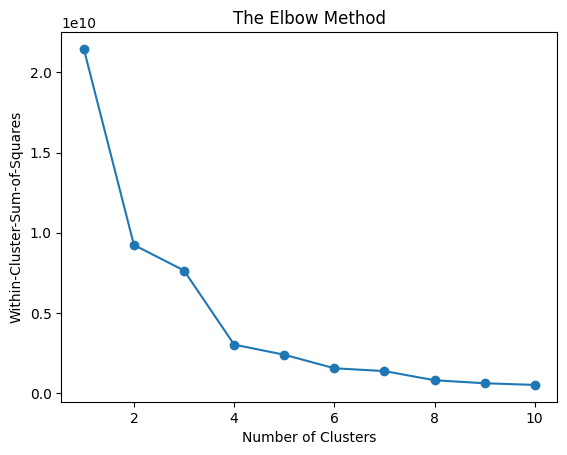

In [103]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(good_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss,marker='o')
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Within-Cluster-Sum-of-Squares");

We can reasonably choose 3 or 4 clusters as the optimal number of customer segments, since beyond that point the improvement in clustering performance becomes marginal. 

This helps in simplifying the segmentation while still capturing key differences in customer behavior.

### Use Dendrogram to choose the number of clusters

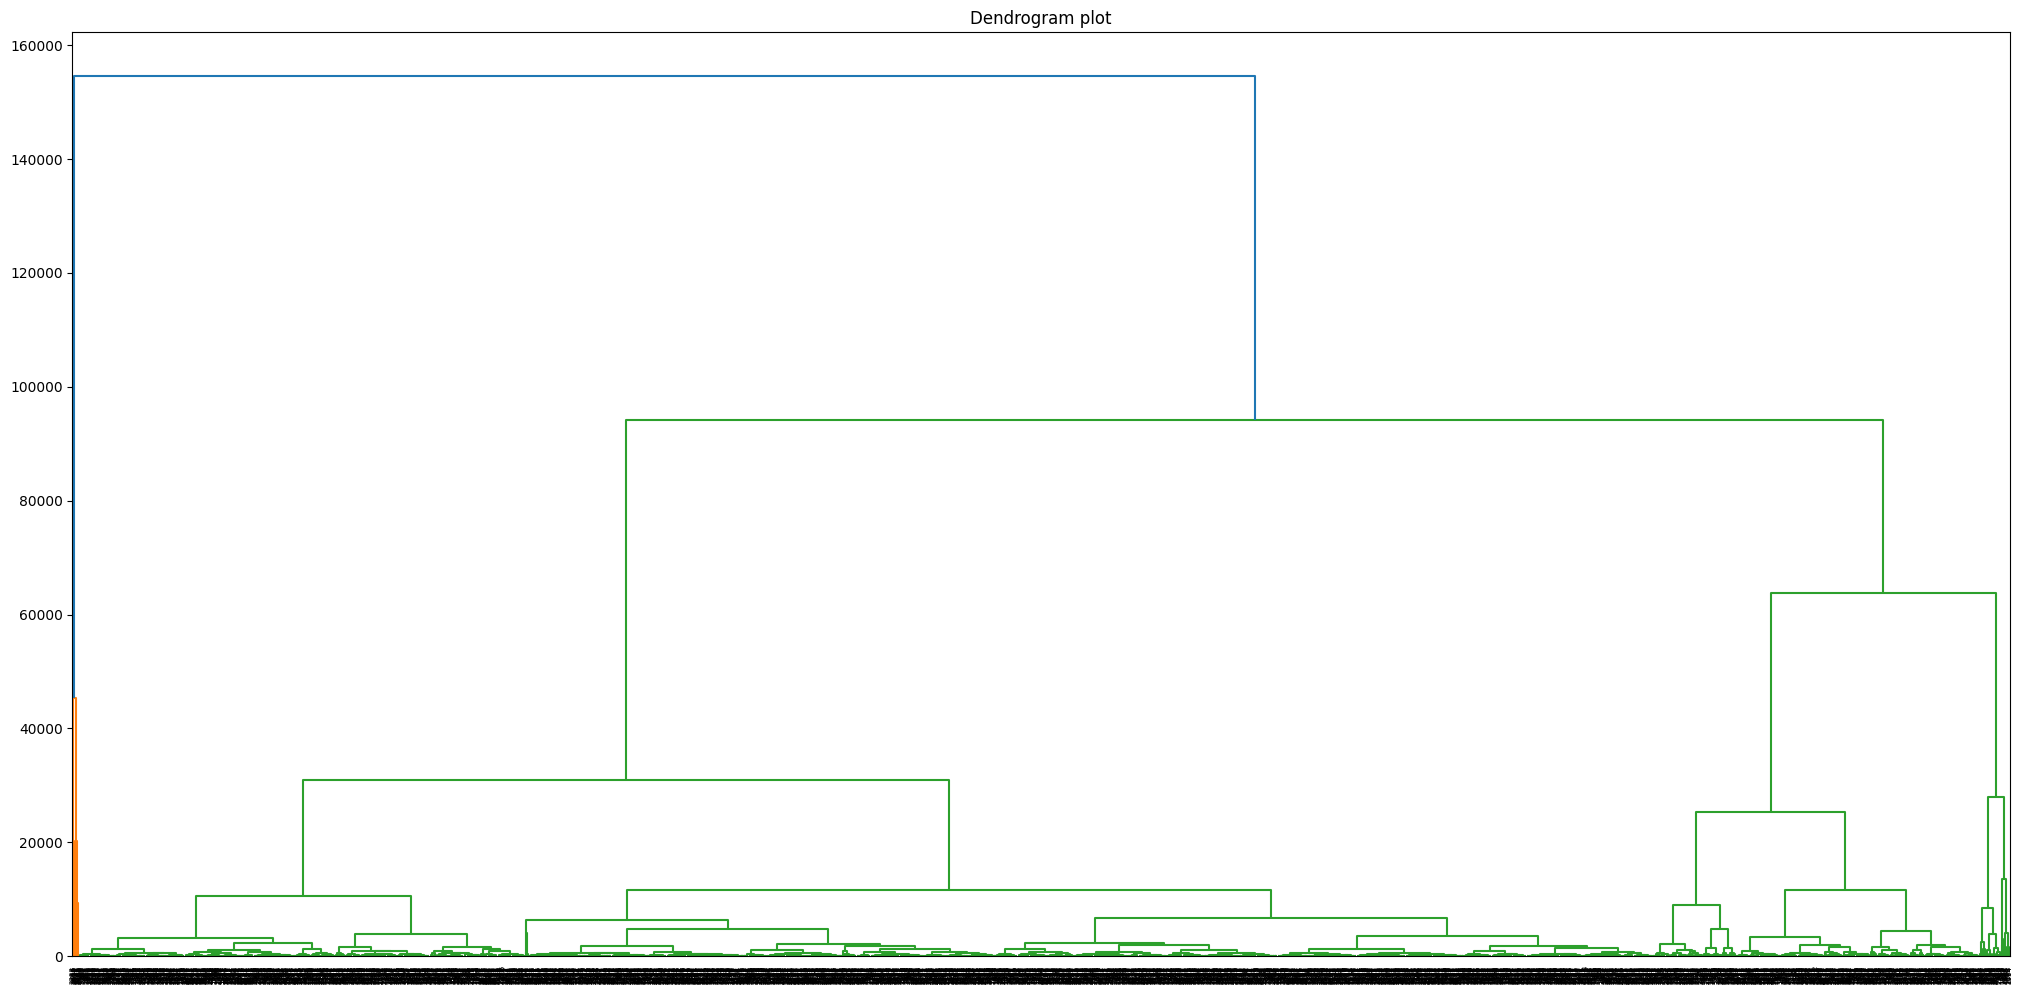

In [104]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(25,12))
dendrogram=sch.dendrogram(sch.linkage(good_data,method = 'ward'))
plt.title('Dendrogram plot')
plt.show()

Just like the Elbow Method, this dendrogram also suggests that 3 or 4 clusters would be a reasonable choice. 

This confirms the elbow method's result and supports a stable segmentation into a small number of distinct customer groups.

___
# Apply to data

In [105]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

### Instantiate the KMeans model with the number of clusters you found, fit and predict

In [106]:
X = good_data.values
kmeans = KMeans(n_clusters=4, init='k-means++')
y_kmeans = kmeans.fit_predict(X)

### The cluster's centers

In [107]:
kmeans.cluster_centers_

array([[2.63975880e+03, 1.50398252e+02, 4.06379526e+01],
       [3.23429975e+04, 1.27583333e+02, 2.39166667e+01],
       [5.37675281e+02, 4.31210542e+01, 1.10404229e+02],
       [9.20274828e+03, 1.10327586e+02, 3.44827586e+01]])

### Check the silhouette score of the kmeans algorithm and the Gaussian Mixture algorithm

In [108]:
clusteted=GaussianMixture(n_components=4).fit(X)
preds=clusteted.predict(X)
print(f'KMeans Score: {silhouette_score(X,y_kmeans)}')
print(f'Gaussian Mixture Score: {silhouette_score(X,preds)}')

KMeans Score: 0.6892788614543035
Gaussian Mixture Score: 0.38653077474019937


### Create a new data frame that will show us what cluster each index were assigned

In [109]:
details = [(name,cluster) for name, cluster in zip(good_data.index,y_kmeans)]
labels =['Index', 'Cluster']
df = pd.DataFrame.from_records(details, columns=labels)
df.head(n=10)

,Index,Cluster
0,0,2
1,1,0
2,2,0
3,3,0
4,4,2
5,5,2
6,6,2
7,7,2
8,8,2
9,9,0


### Create a new column for the final data frame that contains the predictions

In [110]:
good_data['Pred'] = y_kmeans

### Print the head of the final data frame

In [111]:
good_data.head()

,Total_Amount_Spent,Count_invoice,Last_transaction,Pred
0,0.00,2,325,2
1,4310.00,182,1,0
2,1797.24,31,74,0
3,1757.55,73,18,0
4,334.40,17,309,2


### Print a scatterplot of the total amount spent against the count invoice based off of the clusters prediction

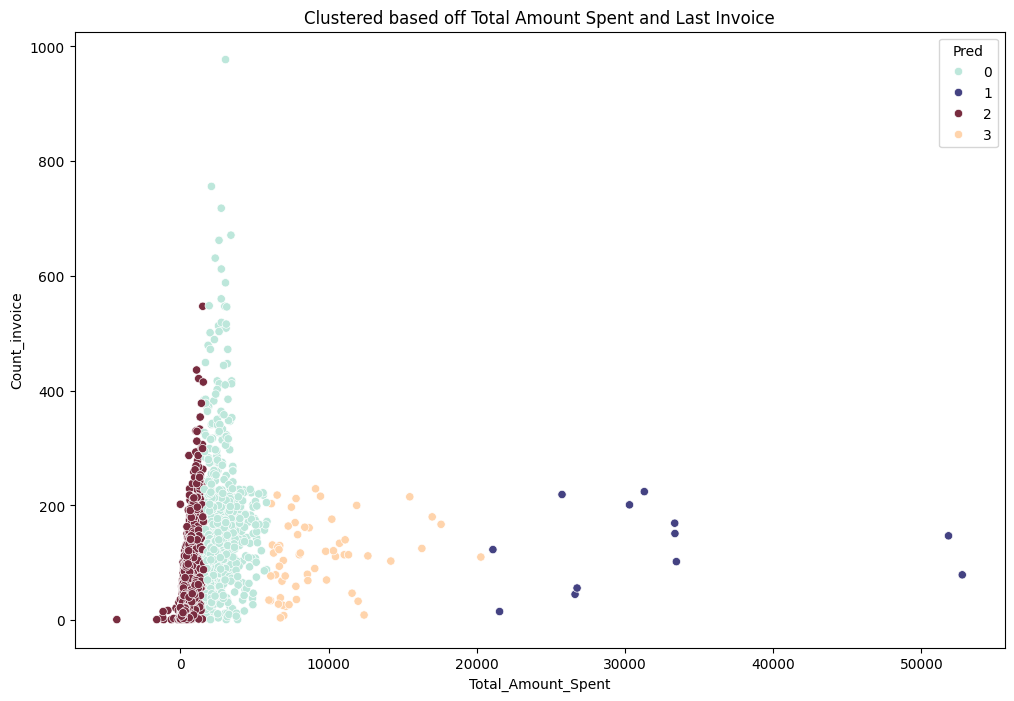

In [113]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x=good_data['Total_Amount_Spent'],
    y=good_data['Count_invoice'],
    hue=good_data['Pred'],
    palette='icefire'
)
plt.title('Clustered based off Total Amount Spent and Last Invoice')
plt.show()

* Cluster 0 (light blue): These customers made moderate to high numbers of purchases, but spent a relatively low amount per transaction. Possibly frequent, low-value buyers.

* Cluster 1 (dark blue): These are the high spenders, with some spending over 50,000 units in total. However, their number of transactions is relatively low, meaning they likely made a few large purchases — possibly wholesalers or bulk buyers.

* Cluster 2 (maroon/dark red): This is the largest group, concentrated near the origin. They made few purchases and spent very little — likely low-value or one-time customers.

* Cluster 3 (peach): Customers here spent a moderate amount and had a medium number of invoices. They fall between low-value and high-value segments — possibly mid-tier regular buyers.

### Print a scatterplot of the total amount spent against the last transaction based off of the clusters prediction

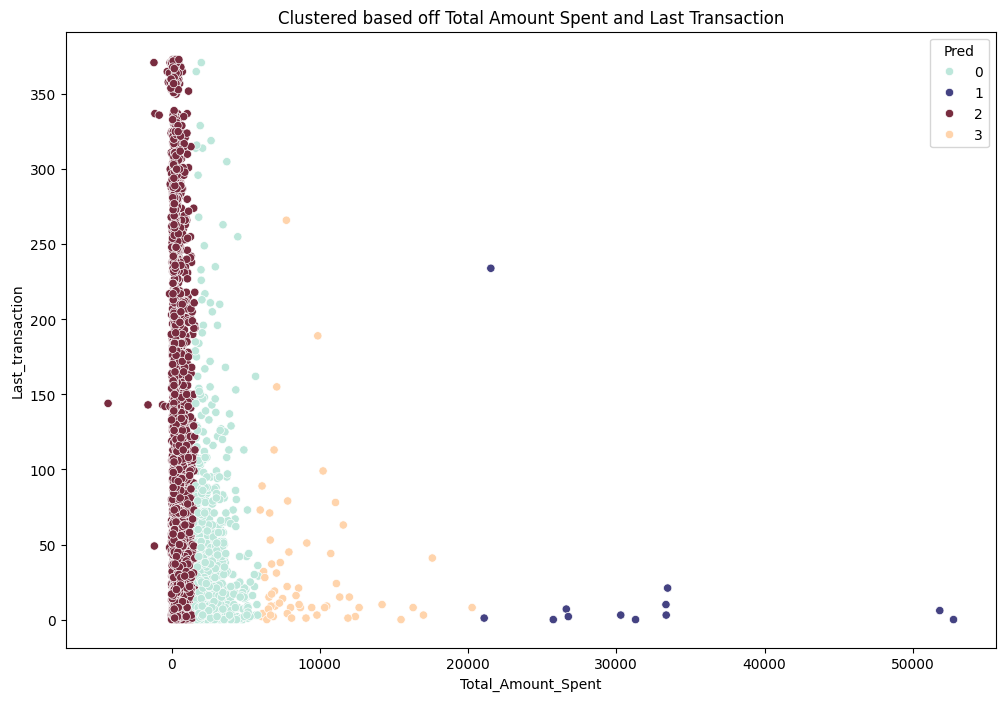

In [114]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=good_data,
    x='Total_Amount_Spent',
    y='Last_transaction',
    hue='Pred',
    palette='icefire'
)
plt.title('Clustered based off Total Amount Spent and Last Transaction')
plt.show()

* Cluster 2 (dark red): Represents customers with low spending and high recency values (i.e., they haven't bought anything in a long time).Likely to be inactive, low-value customers.

* Cluster 0 (light blue): Low to moderate spenders with medium recency, meaning they are somewhat active. Could be targeted for re-engagement campaigns.

* Cluster 3 (peach): Moderate spenders who made recent transactions (low recency values). These are active, medium-value customers and can be nurtured into high-value ones.

* Cluster 1 (dark blue): Very high spenders who made their last purchase recently. These are top/high-value and loyal customers — highly valuable for retention and loyalty programs.

### Print a scatterplot of the last transaction against the Count invoice based off of the clusters prediction

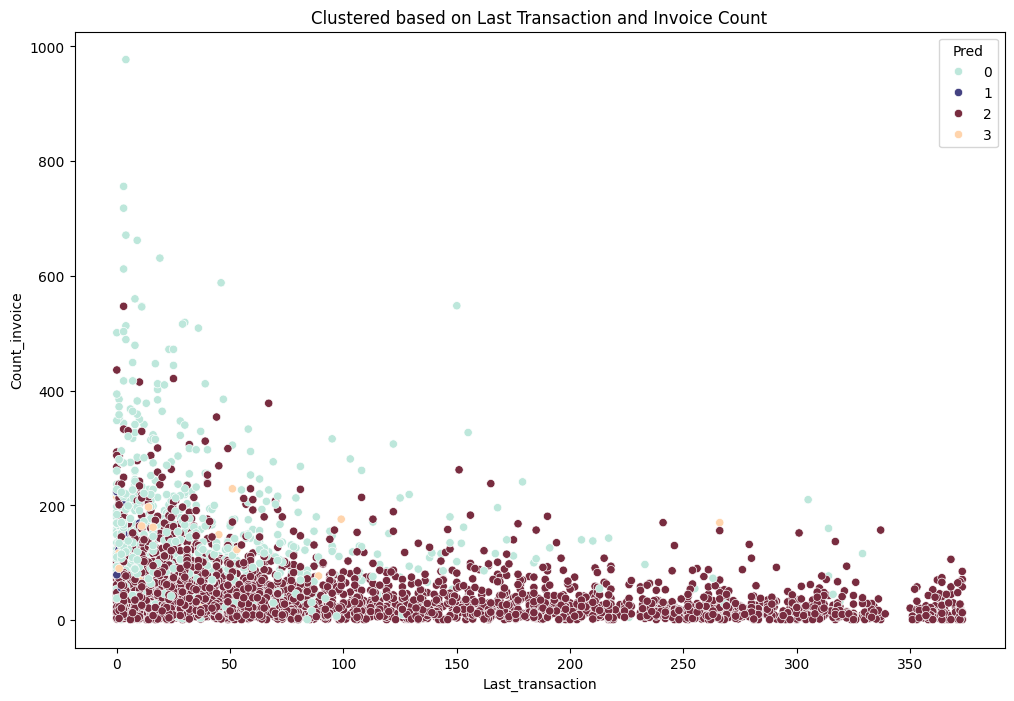

In [116]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=good_data,
    x='Last_transaction',
    y='Count_invoice',
    hue='Pred',
    palette='icefire'
)
plt.title('Clustered based on Last Transaction and Invoice Count')
plt.show()

* Cluster 2 (dark red): Dominates the plot and represents customers who made few transactions and have high recency values — meaning they haven't purchased for a long time. These are likely inactive or one-time customers.

* Cluster 0 (light blue): Consists of customers who made many purchases, most of them relatively recently (low recency values). These are loyal and active customers, potentially high-value.

* Cluster 1 (dark blue): Very few data points, representing customers with low frequency but also very recent purchases — possibly new customers or special cases.

* Cluster 3 (peach): A small group with moderate frequency and low recency, meaning they’re fairly active, perhaps good candidates for retention campaigns.

### Print a 3D plot of the three features based off of the clusters prediction

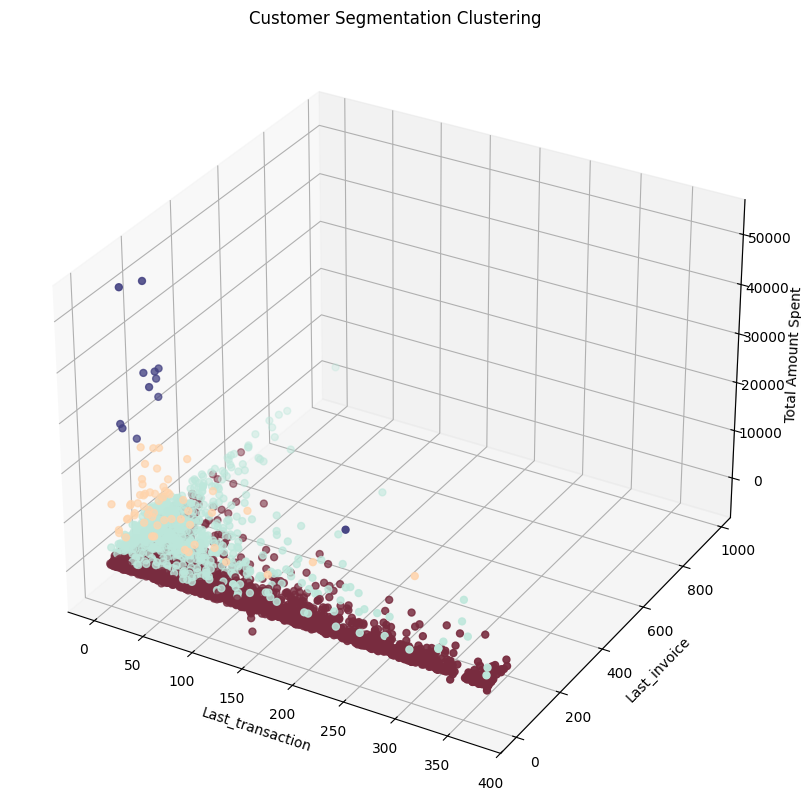

In [117]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(good_data['Last_transaction'],
           good_data['Count_invoice'],
           good_data['Total_Amount_Spent'],
           c=good_data['Pred'], cmap='icefire',s=25)

ax.set_xlabel('Last_transaction')
ax.set_ylabel('Last_invoice')
ax.set_zlabel('Total Amount Spent')
plt.title('Customer Segmentation Clustering')
plt.show()

### Conclusion

We performed customer segmentation using clustering techniques based on three key behavioral features: total amount spent, number of invoices, and recency (last transaction). The optimal number of clusters was determined using both the Elbow Method and Dendrogram analysis, which pointed to 3–4 distinct groups. 

Based on this, we applied clustering (e.g., KMeans) and labeled each customer with a predicted segment. The visualizations helped us understand how customers differ in spending patterns, purchase frequency, and recent activity.

From the scatterplots, we identified clear customer types: 
one group includes high-value, active customers who buy frequently and recently; another includes low-value, inactive customers who made few purchases a long time ago. We also observed mid-tier segments, including moderate spenders and newly active customers. 

These insights enable the company to apply personalized strategies — such as loyalty programs for top customers, re-engagement campaigns for inactive ones, and growth opportunities for mid-tier clients.